In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.metrics import r2_score
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
timelimit = 3600
increment = 5

In [3]:
#read data 
train_set = pd.read_csv('training_data.csv')
test_set = pd.read_csv('test_data.csv')

#divide train and test data in to X and y
X_train = np.array(train_set.iloc[0:,1:])
y_train = np.array(train_set['y'])
X_test = np.array(test_set.iloc[0:,1:])
y_test = np.array(test_set['y'])

#shuffle the indices for the train data  
shuffled_train_data_index = np.random.permutation(train_set.index)
train_df_shuffled = train_set.iloc[shuffled_train_data_index]

#create new X and y set with shuffled index
X_train_shuffled = np.array(train_df_shuffled.iloc[0:,1:])
y_train_shuffled = np.array(train_df_shuffled['y'])

#M for big m
M=100

In [4]:
def find_coeff_using_gurobi(X_kfold_train,y_kfold_train,k,n,m):
        
        #define X be the n x (m+1) matrix that has its first column made up entirely 
        #of 1s and columns 2 to (m+1) have the data from the m independent variables
        X_matrix = np.ones((n,m+1))
        for i in range(n):        
            X_matrix[i, 1:] = X_kfold_train[i,:]
            
        #define Q_matrix as the upper left corner of the matrix is equal to XTX
        #and all other values are zero
        Q_matrix = np.zeros((2*m+1, 2*m+1))
        Q_matrix[:m+1,:m+1] = X_matrix.T @ X_matrix
        
        #define C as linear term of the objective to be a (2m+1) x 1 vector 
        #where the first (m+1) components are -2yTX, and the rest are zeros
        C = np.zeros(2*m+1)
        C[:m+1] = -2*(y_kfold_train.T) @ X_matrix
        
        # define A_matrix
        A_matrix = np.zeros((2*m+1, 2*m+1))
        
        # imply constraint to validate only k stocks are chosen 
        A_matrix[-1 ,(m+1):] = 1

        # imply big M constraints for (weights - M*binary) <=0 and (weights + M*binary) >=0
        np.fill_diagonal(A_matrix[:m,1:m+1],1) 
        np.fill_diagonal(A_matrix[:m,m+1:2*m+1],-M) 
        np.fill_diagonal(A_matrix[m:-1,1:m+1],1) 
        np.fill_diagonal(A_matrix[m:-1,m+1:2*m+1],M) 
        
        #solve gurobi
        sense = np.array(['<']*m + ['>']*m + ['<'])
        ndxMod = gp.Model()
        ndxMod_x = ndxMod.addMVar(len(Q_matrix),vtype=['C']*(m+1)+['B']*m,
                                  lb=np.array([np.NINF]+[-M]*m+[np.NINF]*m)) 
        ndxMod_con = ndxMod.addMConstrs(A_matrix, ndxMod_x, sense, np.concatenate((np.zeros(2*m), [k])))
        ndxMod.setMObjective(Q_matrix, C, 0, sense=gp.GRB.MINIMIZE)
        ndxMod.Params.OutputFlag = 0
        ndxMod.setParam('TimeLimit', timelimit)
        ndxMod.optimize()
        
        return ndxMod_x.x[:m+1]
      

In [5]:
#kfold ccross validation

kfold_c = KFold(n_splits=10)
error_dict={}

if os.path.exists('opti_proj_3_error_results.csv'):
    error_df = pd.read_csv('opti_proj_3_error_results.csv')
else:
    for k in np.arange(0,train_set.shape[1],increment)[1:]:
        sse=0
        i=0
        for train_kfold_index, holdout_kfold_index in kfold_c.split(X_train_shuffled):
            X_kfold_train, X_kfold_holdout = X_train_shuffled[train_kfold_index], X_train_shuffled[holdout_kfold_index]
            y_kfold_train, y_kfold_holdout = y_train_shuffled[train_kfold_index], y_train_shuffled[holdout_kfold_index]

            #store n and m, where n is number of rows and m is number of variables
            n,m=X_kfold_train.shape[0],X_kfold_train.shape[1] 
            nh,mh=X_kfold_holdout.shape[0],X_kfold_holdout.shape[1]

            #get coeff for the k value defined
            calculated_coeff=find_coeff_using_gurobi(X_kfold_train,y_kfold_train,k,n,m)

            #Similarily for X_kfold_holdout define X be the n x (m+1) matrix that has its first column made up entirely 
            #of 1s and columns 2 to (m+1) have the data from the m independent variables
            X_matrix_holdout = np.ones((nh,mh+1))
            for i in range(nh):        
                X_matrix_holdout[i, 1:] = X_kfold_holdout[i,:]

            #calculate take the sum of squared entries of this vector, we can multiply (𝑋 𝛽 − 𝑦)T ∗ (𝑋 𝛽 − 𝑦)
            X_beta = X_matrix_holdout @ calculated_coeff
            sse += np.transpose(X_beta - y_kfold_holdout) @ (X_beta - y_kfold_holdout)

        print('Successfully ran for k=',k,' with SSE as:',sse)
        error_dict[sse] = k

    error_df=pd.DataFrame.from_dict(error_dict.items()).rename(columns={0: "error_val", 1: "k"})
    error_df.to_csv('opti_proj_3_error_results.csv',index=False)


#find the best value of k
best_k=error_df[error_df['error_val']==min(error_df['error_val'])]['k'].iloc[0]
print('Best value of k:', best_k)
print(error_df)



Best value of k: 10
    error_val   k
0  911.593278   5
1  703.841894  10
2  777.854292  15
3  790.983632  20
4  807.744838  25
5  834.906364  30
6  823.522707  35
7  833.062216  40
8  838.028403  45
9  835.636726  50


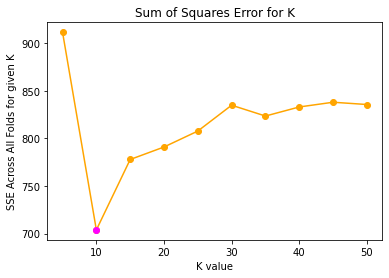

In [6]:
#plot SSE
plt.plot(error_df['k'],error_df['error_val'], color='orange',marker='o')
plt.title('Sum of Squares Error for K')
plt.xlabel('K value')
plt.ylabel('SSE Across All Folds for given K')

# change color of dot at k = best_k_new
plt.plot(best_k, error_df[error_df['k']==best_k]['error_val'], color='fuchsia',marker='o')

In [7]:
#fit for entire training dataset for k=10
train_coeff = find_coeff_using_gurobi(X_train,y_train,best_k,X_train.shape[0],X_train.shape[1])

#Similarily for X_kfold_holdout define X be the n x (m+1) matrix that has its first column made up entirely 
#of 1s and columns 2 to (m+1) have the data from the m independent variables        
sse_main=0
ntest,mtest=X_test.shape[0],X_test.shape[1]
X_test_matrix= np.zeros((ntest,mtest+1))
X_test_matrix[0:ntest, 0] = 1
for i in range(ntest):        
    X_test_matrix[i, 1:] = X_test[i,:]
        
#calculate MSE

X_beta = X_test_matrix @ train_coeff
sse_main = np.transpose(X_beta - y_test) @ (X_beta - y_test)
print ("For Gurobi approach ::\n")
print("1. MSE for : ",mean_squared_error(y_test, X_beta))
print("2. R2 score for : ",r2_score(y_test, X_beta))
print("3. Total number of variables chosen : ",best_k)
print("4. SSE for : ",sse_main)
print("5. Training co-eff chosen : \n\n",train_coeff)



Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19
For Gurobi approach ::

1. MSE for :  2.3365439645525234
2. R2 score for :  0.8586682910020946
3. Total number of variables chosen :  10
4. SSE for :  116.82719822762616
5. Training co-eff chosen : 

 [ 0.97252408  0.          0.          0.          0.          0.
  0.          0.          0.         -2.30820726  0.          0.
  0.          0.          0.         -0.51832612 -0.20416201  0.
  0.          0.          0.          0.          0.         -1.55914318
  0.86697336  0.         -1.31191942  0.          0.          0.
  0.          0.          0.          0.          0.4081653   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.78147489  0.          0.88738292
 -0.28229213  0.          0.        ]


In [8]:
#LASSO

lasso_reg = linear_model.LassoCV(cv=10,normalize=True).fit(X_train, y_train)

#calculate MSE
print ("For Lasso approach ::\n")
print("1. MSE for : ",mean_squared_error(y_test, lasso_reg.predict(X_test)))
print("2. R2 score for : ",r2_score(y_test, lasso_reg.predict(X_test)))
print("3. Total number of variables chosen : ",(lasso_reg.coef_ != 0).sum())
print("4. Alpha value : ",lasso_reg.alpha_)
print("5. Training co-eff chosen : \n\n",lasso_reg.coef_)

For Lasso approach ::

1. MSE for :  2.3597086675768337
2. R2 score for :  0.8572671159690018
3. Total number of variables chosen :  18
4. Alpha value :  0.0057453437864455085
5. Training co-eff chosen : 

 [-0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -2.11561506  0.         -0.06043079 -0.
 -0.         -0.         -0.41674549 -0.18155256  0.          0.
 -0.          0.          0.         -0.19710223 -1.3655275   0.73510021
 -0.         -1.30018578  0.          0.          0.06390289  0.
 -0.          0.         -0.10737966  0.25392747  0.02138366  0.
  0.          0.         -0.21159473  0.         -0.          0.
  0.          0.01152326  1.53171531 -0.01408773  0.6504778  -0.09757869
  0.          0.        ]


In [9]:
#comparison of Lasso and Gurobi optimization approach

lasso_series=pd.concat([pd.Series(lasso_reg.intercept_),pd.Series(lasso_reg.coef_)]).reset_index()[0]

comparison_df=pd.concat([lasso_series, pd.Series(train_coeff)],axis=1)
comparison_df.columns = ['Lasso_coeff','Gurobi_coeff']
comparison_df

,Lasso_coeff,Gurobi_coeff
0,1.006196,0.972524
1,-0.000000,0.000000
2,-0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,-0.000000,0.000000
6,0.000000,0.000000
7,-0.000000,0.000000
8,-0.000000,0.000000
9,-2.115615,-2.308207


# Viz

In [10]:
#cross validating k=6 to k=14

kfold_c = KFold(n_splits=10)
error_dict={}

if os.path.exists('opti_proj_15_error_results.csv'):
    error_df_new = pd.read_csv('opti_proj_15_error_results.csv')
else:
    for k in range(best_k-4,best_k+5):
        sse=0
        i=0
        for train_kfold_index, holdout_kfold_index in kfold_c.split(X_train_shuffled):
            X_kfold_train, X_kfold_holdout = X_train_shuffled[train_kfold_index], X_train_shuffled[holdout_kfold_index]
            y_kfold_train, y_kfold_holdout = y_train_shuffled[train_kfold_index], y_train_shuffled[holdout_kfold_index]

            #store n and m, where n is number of rows and m is number of variables
            n,m=X_kfold_train.shape[0],X_kfold_train.shape[1] 
            nh,mh=X_kfold_holdout.shape[0],X_kfold_holdout.shape[1]

            #get coeff for the k value defined
            calculated_coeff=find_coeff_using_gurobi(X_kfold_train,y_kfold_train,k,n,m)

            #Similarily for X_kfold_holdout define X be the n x (m+1) matrix that has its first column made up entirely 
            #of 1s and columns 2 to (m+1) have the data from the m independent variables
            X_matrix_holdout = np.ones((nh,mh+1))
            for i in range(nh):        
                X_matrix_holdout[i, 1:] = X_kfold_holdout[i,:]

            #calculate take the sum of squared entries of this vector, we can multiply (𝑋 𝛽 − 𝑦)T ∗ (𝑋 𝛽 − 𝑦)
            X_beta = X_matrix_holdout @ calculated_coeff
            sse += np.transpose(X_beta - y_kfold_holdout) @ (X_beta - y_kfold_holdout)

        print('Successfully ran for k=',k,' with SSE as:',sse)
        error_dict[sse] = k

    error_df_new=pd.DataFrame.from_dict(error_dict.items()).rename(columns={0: "error_val", 1: "k"})
    error_df_new.to_csv('opti_proj_15_error_results.csv',index=False)


#find the best value of k
best_k_new=error_df_new[error_df_new['error_val']==min(error_df_new['error_val'])]['k'].iloc[0]
print('Best value of k:', best_k_new)
print(error_df_new)

Best value of k: 8
    error_val   k
0  753.828517   6
1  705.898248   7
2  664.154672   8
3  714.521958   9
4  707.593190  10
5  703.462262  11
6  734.842642  12
7  766.615278  13
8  760.874870  14


In [11]:
if os.path.exists('test_error_new.csv'):
    test_error_df = pd.read_csv('test_error_new.csv')

else:    
    test_error = []

    for k in range(best_k-4,best_k+5):

        #fit for entire training dataset for k=10
        train_coeff = find_coeff_using_gurobi(X_train,y_train,k,X_train.shape[0],X_train.shape[1])

        #Similarily for X_kfold_holdout define X be the n x (m+1) matrix that has its first column made up entirely 
        #of 1s and columns 2 to (m+1) have the data from the m independent variables        
        sse_main=0
        ntest,mtest=X_test.shape[0],X_test.shape[1]
        X_test_matrix= np.zeros((ntest,mtest+1))
        X_test_matrix[0:ntest, 0] = 1
        for i in range(ntest):        
            X_test_matrix[i, 1:] = X_test[i,:]
                
        #calculate MSE

        X_beta = X_test_matrix @ train_coeff
        sse_main = np.transpose(X_beta - y_test) @ (X_beta - y_test)
        mse = mean_squared_error(y_test, X_beta)
        test_error.append(mse)

    # create a df of test_error
    test_error_df = pd.DataFrame(test_error, columns = ['test_error'])
    test_error_df['k'] = range(best_k-4,best_k+5)
    test_error_df

    # save
    test_error_df.to_csv('test_error_new.csv',index=False)

test_error_df

,test_error,k
0,2.148449,6
1,2.197658,7
2,2.102457,8
3,1.985658,9
4,2.336544,10
5,2.325883,11
6,2.271976,12
7,2.394877,13
8,2.362553,14


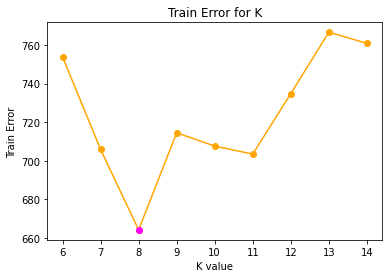

In [29]:
# plot train_error
plt.plot(error_df_new['k'], error_df_new['error_val'], color='orange',marker='o')
plt.title('Train Error for K')
plt.xlabel('K value')
plt.ylabel('Train Error')

# change color of dot at k = best_k_new
plt.plot(best_k_new, error_df_new[error_df_new['k']==best_k_new]['error_val'], color='fuchsia',marker='o')

# store plot as trainfig
trainfig = plt.gcf()


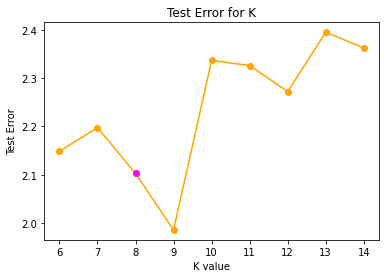

In [13]:
# plot test_error
plt.plot(test_error_df['k'], test_error_df['test_error'], color='orange',marker='o')
plt.title('Test Error for K')
plt.xlabel('K value')
plt.ylabel('Test Error')

# change color of dot at k = best_k_new
plt.plot(best_k_new, test_error_df[test_error_df['k']==best_k_new]['test_error'], color='fuchsia',marker='o')

# store plot as testfig
testfig = plt.gcf()


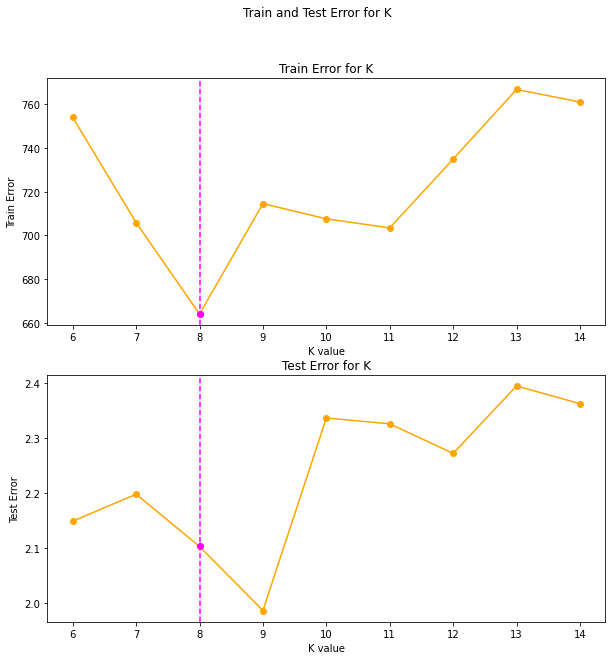

In [30]:
#plot trainfig and test fig vertically on a figsize of 10,10 and vertical lines at best_k_new
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
fig.suptitle('Train and Test Error for K')
ax1.plot(error_df_new['k'], error_df_new['error_val'], color='orange',marker='o')
ax1.set_title('Train Error for K')
ax1.set_xlabel('K value')
ax1.set_ylabel('Train Error')
ax1.plot(best_k_new, error_df_new[error_df_new['k']==best_k_new]['error_val'], color='fuchsia',marker='o')
ax2.plot(test_error_df['k'], test_error_df['test_error'], color='orange',marker='o')
ax2.set_title('Test Error for K')
ax2.set_xlabel('K value')
ax2.set_ylabel('Test Error')
ax2.plot(best_k_new, test_error_df[test_error_df['k']==best_k_new]['test_error'], color='fuchsia',marker='o')
ax1.axvline(x=best_k_new, color='fuchsia', linestyle='--')
ax2.axvline(x=best_k_new, color='fuchsia', linestyle='--')

In [15]:
#fit for entire training dataset for k=10
train_coeff = find_coeff_using_gurobi(X_train,y_train,best_k,X_train.shape[0],X_train.shape[1])

#Similarily for X_kfold_holdout define X be the n x (m+1) matrix that has its first column made up entirely 
#of 1s and columns 2 to (m+1) have the data from the m independent variables        
sse_main=0
ntest,mtest=X_test.shape[0],X_test.shape[1]
X_test_matrix= np.zeros((ntest,mtest+1))
X_test_matrix[0:ntest, 0] = 1
for i in range(ntest):        
    X_test_matrix[i, 1:] = X_test[i,:]

#calculate MSE

X_beta = X_test_matrix @ train_coeff
sse_main = np.transpose(X_beta - y_test) @ (X_beta - y_test)
mse = mean_squared_error(y_test, X_beta)

In [16]:
# create a dataframe with mean_squaredrror, best_k, r2_score, and coeff
df = pd.DataFrame({'MSE': [mean_squared_error(y_test, X_beta)], 'Variables Selected': [best_k], 'R-Square': [r2_score(y_test, X_beta)], 'Weight-Sum': [np.sum(np.abs(train_coeff))]})
df = df.T

# create a dataframe with mean_squaredrror, lasso_reg, r2_score, and coeff
df2 = pd.DataFrame({'MSE': [mean_squared_error(y_test, lasso_reg.predict(X_test))], 'Variables Selected': [(lasso_reg.coef_ != 0).sum()], 'R-Square': [r2_score(y_test, lasso_reg.predict(X_test))], 'Weight-Sum': [np.sum(np.abs(lasso_reg.coef_))]})
df2 = df2.T

# combine df and df2
df3 = pd.concat([df, df2], axis=1)
df3.columns = ['MIQP', 'Lasso']


df3 = df3.T
# change variables selected to int
df3['Variables Selected'] = df3['Variables Selected'].astype(int)
df3 = df3[['Variables Selected', 'MSE', 'R-Square', 'Weight-Sum']]


# round the values
df3 = df3.round(3)
df3

,Variables Selected,MSE,R-Square,Weight-Sum
MIQP,10,2.337,0.859,11.101
Lasso,18,2.360,0.857,9.336


In [17]:
# combine lasso intercept and coef
lasso_testo = np.append(lasso_reg.intercept_, lasso_reg.coef_)
lasso_testo

array([ 1.00619635, -0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -2.11561506,
        0.        , -0.06043079, -0.        , -0.        , -0.        ,
       -0.41674549, -0.18155256,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.19710223, -1.3655275 ,  0.73510021,
       -0.        , -1.30018578,  0.        ,  0.        ,  0.06390289,
        0.        , -0.        ,  0.        , -0.10737966,  0.25392747,
        0.02138366,  0.        ,  0.        ,  0.        , -0.21159473,
        0.        , -0.        ,  0.        ,  0.        ,  0.01152326,
        1.53171531, -0.01408773,  0.6504778 , -0.09757869,  0.        ,
        0.        ])

In [18]:
# create a df of lasso_reg.coef_
lasso_coeff_df = pd.DataFrame(np.append(lasso_reg.intercept_, lasso_reg.coef_), columns = ['Lasso Coeff'])
lasso_coeff_df['Variable'] = "X"+lasso_coeff_df.index.astype(str)
lasso_coeff_df = lasso_coeff_df[['Variable', 'Lasso Coeff']].set_index('Variable')
lasso_coeff_df

# create a df of train_coeff
train_coeff_df = pd.DataFrame(train_coeff, columns = ['MIQP Coeff'])
train_coeff_df['Variable'] = "X"+train_coeff_df.index.astype(str)
train_coeff_df = train_coeff_df[['Variable', 'MIQP Coeff']].set_index('Variable')
train_coeff_df

# combine lasso_coeff_df and train_coeff_df
coef_df = pd.concat([lasso_coeff_df, train_coeff_df], axis=1)
coef_df = coef_df.round(3)
coef_df

,Lasso Coeff,MIQP Coeff
Variable,,
X0,1.006,0.973
X1,-0.000,0.000
X2,-0.000,0.000
X3,0.000,0.000
X4,0.000,0.000
X5,-0.000,0.000
X6,0.000,0.000
X7,-0.000,0.000
X8,-0.000,0.000


In [19]:
# drop 0 in coef_df
coef_df = coef_df[(coef_df.T != 0).any()]
coef_df

,Lasso Coeff,MIQP Coeff
Variable,,
X0,1.006,0.973
X9,-2.116,-2.308
X11,-0.060,0.000
X15,-0.417,-0.518
X16,-0.182,-0.204
X22,-0.197,0.000
X23,-1.366,-1.559
X24,0.735,0.867
X26,-1.300,-1.312


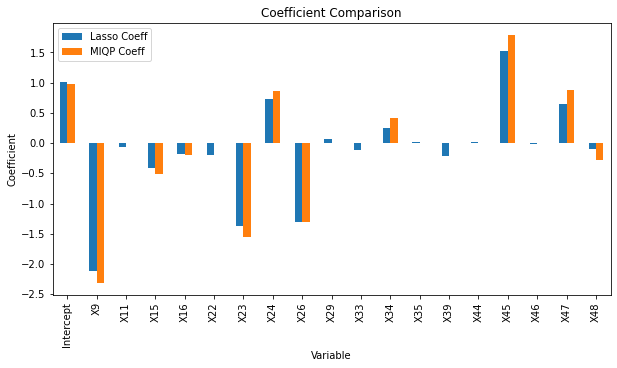

In [20]:
# change coef_df index X0 to Intercept
coef_df.index = ['Intercept' if x=='X0' else x for x in coef_df.index]

# plot coef_df
coef_df.plot(kind='bar', figsize=(10,5))
plt.title('Coefficient Comparison')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.show()

In [21]:
traindf = train_set.iloc[:,1:]
traincorrdf = traindf[coef_df.index[1:]]
traincorrs = traincorrdf.corr()

In [22]:
# coef_df where MIQP Coeff is 0
lasso_extra = coef_df[coef_df['MIQP Coeff']==0].index
lasso_extra

Index(['X11', 'X22', 'X29', 'X33', 'X35', 'X39', 'X44', 'X46'], dtype='object')

Text(0.5, 1.0, 'Correlation of Variables Selected')

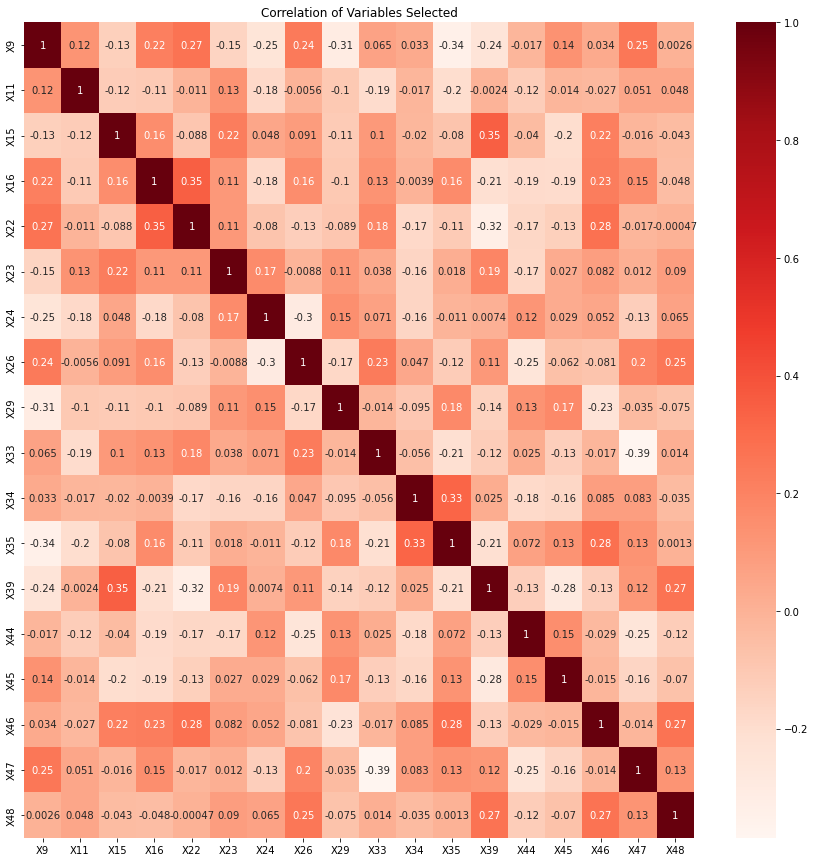

In [23]:
import seaborn as sns

# plot correlation of traincorrdf and change color of lasso_extra
plt.figure(figsize=(15,15))
sns.heatmap(traincorrs, annot=True, cmap='Reds')
plt.title('Correlation of Variables Selected')

In [24]:
##correlations of variables removed from Lasso by MIQP

# create a function that gets the second highest value of a column
def second_max(col, ret):
    corrvar = abs(col).nlargest(2).index[1]
    corr = col[corrvar]
    return [corrvar, corr][ret]

# second max of traincorrdf.corr()[lasso_extra]
lassocorrs = traincorrs[lasso_extra].apply(lambda s: second_max(s,1))
lassocorrs2 = traincorrs[lasso_extra].apply(lambda s: second_max(s,0))


# create a df of lassocorrs and lassocorrs2
lassocorrs_df = pd.DataFrame(lassocorrs, columns = ['Strongest Correlation'])
lassocorrs_df['Correlated Variable'] = lassocorrs2
lassocorrs_df = lassocorrs_df.round(3)

miqp_vars = coef_df[coef_df['MIQP Coeff'] != 0].index[1:]

# add column to lassocorrs_df if correlated variable is in miqp_vars
lassocorrs_df['Selected in MIQP'] = lassocorrs_df['Correlated Variable'].isin(miqp_vars)

lassocorrs_df

,Strongest Correlation,Correlated Variable,Selected in MIQP
X11,-0.199,X35,False
X22,0.347,X16,True
X29,-0.308,X9,True
X33,-0.385,X47,True
X35,-0.344,X9,True
X39,0.349,X15,True
X44,-0.251,X26,True
X46,0.282,X35,False


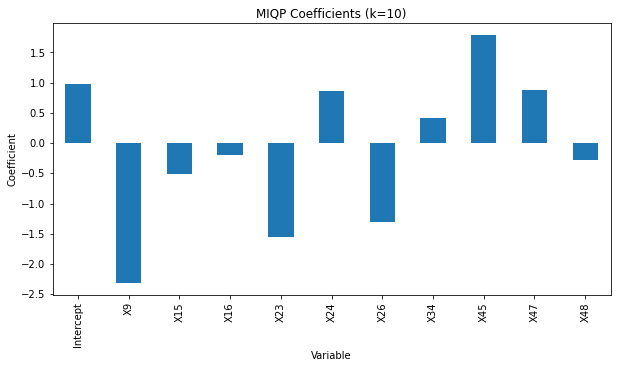

,MIQP Coeff
Intercept,0.973
X9,-2.308
X15,-0.518
X16,-0.204
X23,-1.559
X24,0.867
X26,-1.312
X34,0.408
X45,1.781
X47,0.887


In [25]:
# k=10 betas

# plot coef_df['MIQP']
coef_df['MIQP Coeff'][coef_df['MIQP Coeff'] != 0].plot(kind='bar', figsize=(10,5))
plt.title('MIQP Coefficients (k=10)')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.show()

display(coef_df[['MIQP Coeff']][coef_df['MIQP Coeff'] != 0])

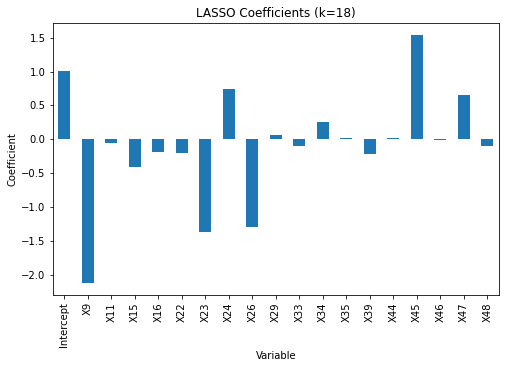

,Lasso Coeff
Intercept,1.006
X9,-2.116
X11,-0.060
X15,-0.417
X16,-0.182
X22,-0.197
X23,-1.366
X24,0.735
X26,-1.300
X29,0.064


In [26]:
# lasso betas

# plot coef_df['Lasso']
coef_df['Lasso Coeff'][coef_df['Lasso Coeff'] != 0].plot(kind='bar', figsize=(8,5))
plt.title('LASSO Coefficients (k=18)')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.show()

display(coef_df[['Lasso Coeff']][coef_df['Lasso Coeff'] != 0])

In [27]:
### adj r-square

def adj_r2(r2, n, k):
    return 1-(1-r2)*(n-1)/(n-k-1)

# lasso adjusted r2
r2 = r2_score(y_test, lasso_reg.predict(X_test))
k = len(lasso_reg.coef_[lasso_reg.coef_ != 0])
n = len(y_test)

lasso_adj_r2 = adj_r2(r2, n, k)

# best_k
#fit for entire training dataset for k=10
train_coeff = find_coeff_using_gurobi(X_train,y_train,best_k,X_train.shape[0],X_train.shape[1])

#Similarily for X_kfold_holdout define X be the n x (m+1) matrix that has its first column made up entirely 
#of 1s and columns 2 to (m+1) have the data from the m independent variables        
sse_main=0
ntest,mtest=X_test.shape[0],X_test.shape[1]
X_test_matrix= np.zeros((ntest,mtest+1))
X_test_matrix[0:ntest, 0] = 1
for i in range(ntest):        
    X_test_matrix[i, 1:] = X_test[i,:]

#calculate MSE

X_beta = X_test_matrix @ train_coeff
sse_main = np.transpose(X_beta - y_test) @ (X_beta - y_test)
mse = mean_squared_error(y_test, X_beta)
sse_null = np.transpose(y_test - np.mean(y_test)) @ (y_test - np.mean(y_test))
miqp_adjr2 = adj_r2(1 - sse_main / sse_null, ntest, best_k)



## best_k_new
#fit for entire training dataset for k=10
train_coeff = find_coeff_using_gurobi(X_train,y_train,best_k_new,X_train.shape[0],X_train.shape[1])

#Similarily for X_kfold_holdout define X be the n x (m+1) matrix that has its first column made up entirely 
#of 1s and columns 2 to (m+1) have the data from the m independent variables        
sse_main=0
ntest,mtest=X_test.shape[0],X_test.shape[1]
X_test_matrix= np.zeros((ntest,mtest+1))
X_test_matrix[0:ntest, 0] = 1
for i in range(ntest):        
    X_test_matrix[i, 1:] = X_test[i,:]

#calculate MSE

X_beta = X_test_matrix @ train_coeff
sse_main = np.transpose(X_beta - y_test) @ (X_beta - y_test)
mse = mean_squared_error(y_test, X_beta)
sse_null = np.transpose(y_test - np.mean(y_test)) @ (y_test - np.mean(y_test))
miqp_adjr2_new = adj_r2(1 - sse_main / sse_null, ntest, best_k)

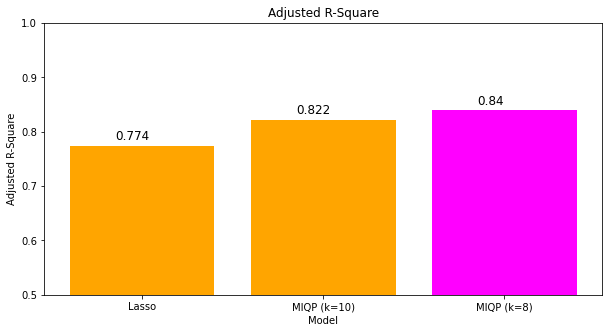

In [28]:
# plot adj r2 and add data labels
plt.figure(figsize=(10,5))
plt.bar(['Lasso', 'MIQP (k=10)'], [lasso_adj_r2, miqp_adjr2], color='orange')
plt.bar(['MIQP (k=8)'], [miqp_adjr2_new], color='fuchsia')
plt.title('Adjusted R-Square')
plt.xlabel('Model')
plt.ylabel('Adjusted R-Square')
plt.ylim(0.5,1)
# add data labels
for i, v in enumerate([lasso_adj_r2, miqp_adjr2, miqp_adjr2_new]):
    plt.text(i-0.15, v+0.01, str(round(v,3)), fontsize=12)
plt.show()